
# **<center>Model for Predicting Credit Card Fraud** </center>
----------

**<br>2023F-T3 BDM 3035 - Big Data Capstone Project 01**
<br>Group 1:
<br>&emsp;&emsp;Jefford Secondes
<br>&emsp;&emsp;Jovi Fez Bartolata
<br>&emsp;&emsp;Luz Zapanta
<br>&emsp;&emsp;Maricris Resma
<br>&emsp;&emsp;Keyvan Amini

--------------------


**PROJECT DESCRIPTION:**

The major goal of the project is to develop a predictive modelling application that effectively predicts credit card fraudulent actions, such as identity theft, financial fraud, and unauthorized access. Various supervised machine learning classifier algorithms will be developed and tested upon to be able to identify the model that gives the best accuracy that satisfies the requirement of greater than 80% accuracy. Historical data will be evaluated using various machine learning models, identifying abnormalities and trends suggestive of fraudulent activities. The fraud detection application, aimed to protect the integrity of Bank of Mississauga's operations, shall be used to mitigate fraudulent transactions. This comprehensive approach addresses both known fraud trends and emergent threats, providing a proactive defense mechanism against developing fraud strategies.

**OBJECTIVES:**

● Retrieve and manage credit card transaction Data from Google Cloud Platform

● Create a machine learning classifier model capable of detecting credit card fraud using Logistic Regression Model, Decision Tree, or Random Forest.

● Improve the adaptability of the model to evolving fraud patterns through continuous learning.

● Reduce false positives to guarantee a seamless and trustworthy user experience.

● Deliver the pickle file that can be integrated into Bank of Mississauga’s organizational systems and databases to assure seamless operation


----------
## Data Preparation
----------

In [ ]:
#For google cloud
# pip install --upgrade google-api-python-client
# pip install --upgrade google-cloud-storage
# https://cloud.google.com/storage/docs/reference/libraries?authuser=1#client-libraries-install-python
try:
    from google.cloud import storage
    import google.cloud.storage
    import json
    import os
    import sys
except Exception as e:
    print("Error : {} ".format(e))

In [ ]:
PATH = os.path.join(os.getcwd() , 'creditfraud-beta-404714-e0536176176a.json')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = PATH

In [ ]:
bucket = storage_client.get_bucket('ccfraudbucket')

In [ ]:
storage_client = storage.Client(PATH)

In [2]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTENC
from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'numpy'

In [3]:
# Load the CSV data into a DataFrame
df_raw = pd.read_csv("./credit_card_transactions-ibm_v2.csv")

In [4]:
df_raw.head(2)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No


In [5]:
df_raw['Year'].unique

<bound method Series.unique of 0           2002
1           2002
2           2002
3           2002
4           2002
            ... 
24386895    2020
24386896    2020
24386897    2020
24386898    2020
24386899    2020
Name: Year, Length: 24386900, dtype: int64>

In [5]:
# Display dataframe information to get more details about the raw data.
df_raw.info()

# Overview of the summary statistics: mean, min, max, std
df_raw.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


,User,Card,Year,Month,Day,Merchant Name,Zip,MCC
count,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.438690e+07,2.150876e+07,2.438690e+07
mean,1.001019e+03,1.351366e+00,2.011955e+03,6.525064e+00,1.571812e+01,-4.769230e+17,5.095644e+04,5.561171e+03
std,5.694612e+02,1.407154e+00,5.105921e+00,3.472355e+00,8.794073e+00,4.758940e+18,2.939707e+04,8.793154e+02
min,0.000000e+00,0.000000e+00,1.991000e+03,1.000000e+00,1.000000e+00,-9.222899e+18,5.010000e+02,1.711000e+03
25%,5.100000e+02,0.000000e+00,2.008000e+03,3.000000e+00,8.000000e+00,-4.500543e+18,2.837400e+04,5.300000e+03
50%,1.006000e+03,1.000000e+00,2.013000e+03,7.000000e+00,1.600000e+01,-7.946765e+17,4.674200e+04,5.499000e+03
75%,1.477000e+03,2.000000e+00,2.016000e+03,1.000000e+01,2.300000e+01,3.189517e+18,7.756400e+04,5.812000e+03
max,1.999000e+03,8.000000e+00,2.020000e+03,1.200000e+01,3.100000e+01,9.223292e+18,9.992800e+04,9.402000e+03


**Observations:**
- The raw data has 24,386,900  observations/rows and 15 variables/columns.
- Y Variable / Dependent Variable is <b>Is Fraud?</b>
- X Variable / Independent Variables will be taken from the other 14 variables 


**Observation**
- Raw data class imbalance has 24,357,143 No and 29,757 Yes
- Majority of the transactions was not fraud. Only 0.122% of the transactions were fraud, therefore, we have an highly imbalanced class.


----------
## Data Pre-Processing
----------

Sample data to work only with 800k records

In [6]:
df_sample = df_raw.sample(n=800000, random_state=1)
df_sample.head(5)

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
4866429,413,1,2011,3,15,07:50,$50.43,Swipe Transaction,-3220758452254689706,Spokane,WA,99208.0,5311,NaN,No
5124282,433,1,2015,9,20,05:30,$53.78,Online Transaction,-2088492411650162548,ONLINE,NaN,NaN,4784,NaN,No
17887935,1442,3,2020,2,10,11:41,$30.98,Chip Transaction,-4113349227963201766,Lakeland,FL,33813.0,5411,NaN,No
7224963,610,2,2017,10,13,18:32,$10.32,Swipe Transaction,6913268435708117971,Albuquerque,NM,87121.0,5912,NaN,No
19812059,1606,1,2009,5,18,10:44,$130.45,Swipe Transaction,4937803722023861373,Stockton,CA,95210.0,5310,NaN,No


In [1]:
df_sample.head(5)

NameError: name 'df_sample' is not defined

In [7]:
df_sample.shape

(800000, 15)

Check Duplicates

In [8]:
# Check for duplicate records
df_sample.duplicated().sum()

0

In [9]:
df_sample.drop_duplicates(inplace=True)

In [10]:
df_sample.shape

(800000, 15)

Check Null values

In [11]:
# Function to get a tabe summarizing input dataframe's dtype, no of unique values and missing values for each feature
def getDataSummary(input_df):
    count_unique_values = []
    for column in input_df:
        # Count unique values for each column
        cnt_unique_values = len(input_df[column].unique())
        count_unique_values.append(cnt_unique_values)

    # Count missing values for each column    
    count_nan = input_df.isna().sum()

    # Summarize column attributes using a dataframe
    data_summary = pd.DataFrame()
    data_summary['data_type'] = input_df.dtypes

    # Add details
    data_summary['count_unique_values'] = count_unique_values
    data_summary['count_null'] = count_nan
    return data_summary

getDataSummary(df_sample)

,data_type,count_unique_values,count_null
User,int64,1978,0
Card,int64,9,0
Year,int64,30,0
Month,int64,12,0
Day,int64,31,0
Time,object,1440,0
Amount,object,32072,0
Use Chip,object,3,0
Merchant Name,int64,30165,0
Merchant City,object,9021,0


**Observations:**
- 3 features(Merchant State, Zip, Errors?) has null or nan values()

In [15]:
# Drop null values
# df_sample.dropna(inplace=True)

# Fill null values
df_sample.fillna('unknown', inplace=True)

In [17]:
# Change Amount to float
df_sample["Amount"]=df_sample["Amount"].str.replace("$","").astype(float)

AttributeError: Can only use .str accessor with string values!

In [18]:
# Verify no more null values
getDataSummary(df_sample)

,data_type,count_unique_values,count_null
User,int64,1978,0
Card,int64,9,0
Year,int64,30,0
Month,int64,12,0
Day,int64,31,0
Time,object,1440,0
Amount,float64,32072,0
Use Chip,object,3,0
Merchant Name,int64,30165,0
Merchant City,object,9021,0


In [19]:
# Extract the hours and minutes from Time to perform a more refined time series analysis
df_sample["Hour"] = df_sample["Time"].str[0:2]
df_sample["Minute"] = df_sample["Time"].str[3:5]
df_sample.drop(['Time'],axis=1, inplace=True)

df_sample.head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
4866429,413,1,2011,3,15,50.43,Swipe Transaction,-3220758452254689706,Spokane,WA,99208.0,5311,unknown,No,07,50
5124282,433,1,2015,9,20,53.78,Online Transaction,-2088492411650162548,ONLINE,unknown,unknown,4784,unknown,No,05,30


**Observation:**
- The updated model data has xxxx observations/rows and xx variables/columns.

#### Transform Target Variable <b>Is Fraud?</b> to numerical value

In [20]:
# Transform Is Fraud? to 1/0 value (Fraud: 1, Not Fraud: 0)
df_sample["Is Fraud?"] = df_sample["Is Fraud?"].replace({'No': 0, 'Yes': 1})
df_sample.head(2)

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
4866429,413,1,2011,3,15,50.43,Swipe Transaction,-3220758452254689706,Spokane,WA,99208.0,5311,unknown,0,07,50
5124282,433,1,2015,9,20,53.78,Online Transaction,-2088492411650162548,ONLINE,unknown,unknown,4784,unknown,0,05,30


----------
## Exploratory Data Analysis
----------


Count:
0    799078
1       922
Name: Is Fraud?, dtype: int64

Distribution:
0    0.998847
1    0.001153
Name: Is Fraud?, dtype: float64


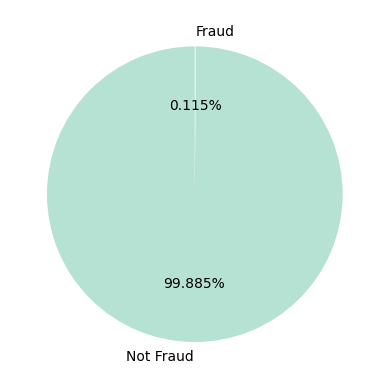

In [21]:
# Distribution of classes
print('\nCount:')
print(df_sample['Is Fraud?'].value_counts())

print('\nDistribution:')
print(df_sample['Is Fraud?'].value_counts() / df_sample.shape[0])

# Visualize distribution with a pie chart
labels = ['Not Fraud', 'Fraud']
colors = ['#B6E2D3', '#FAE8E0']

plt.pie(df_sample['Is Fraud?'].value_counts(), labels = labels, colors = colors, autopct='%.3f%%',startangle=90)
plt.show()

**Observation**
- Sample data class imbalance has 799,078 No and 922 Yes
- Majority of the transactions was not fraud. Only 0.125% of the transactions were fraud, therefore, we have an highly imbalanced class.


#### Divide independent variables into categorical and numerical features

In [22]:
# Identify categorical and numerical features
categorical_features = []
numerical_features = []
for i in df_sample.columns:
    if df_sample[i].dtype == 'object':
        categorical_features.append(i)  # Append to the list of categorical features
    else:
        numerical_features.append(i)    # Append to the list of categorical features

print(f"Categorical Features : {categorical_features}")
print(f"Numerical Features: {numerical_features}")

Categorical Features : ['Use Chip', 'Merchant City', 'Merchant State', 'Zip', 'Errors?', 'Hour', 'Minute']
Numerical Features: ['User', 'Card', 'Year', 'Month', 'Day', 'Amount', 'Merchant Name', 'MCC', 'Is Fraud?']


Boxplot: Visualize the distribution and identify outliers for each variable

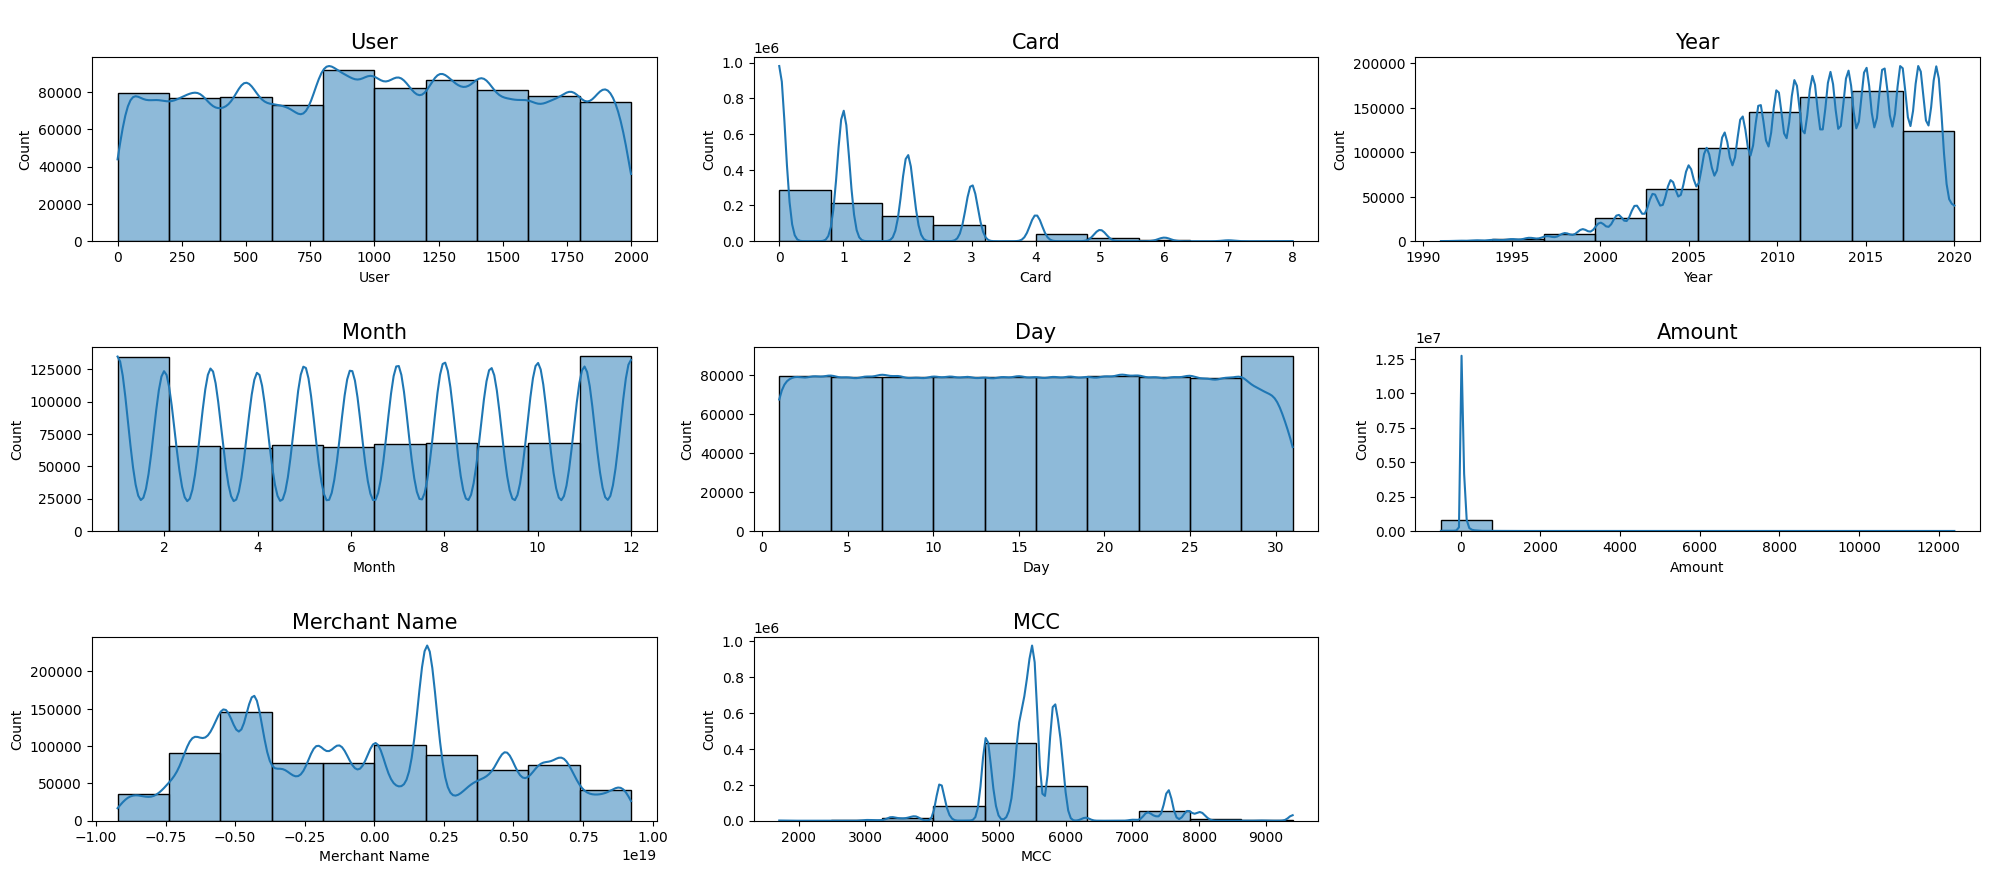

In [23]:
# Plot the histogram of numerical features
plt.figure(figsize = (20, 20))
plot_number = 1

bins_num= 10
for eachCol in numerical_features:
    if eachCol != "Is Fraud?":
        x = df_sample[eachCol]
        y = df_sample
        ax = plt.subplot(7, 3, plot_number)
        sns.histplot(x = x, data = y, ax = ax, bins = bins_num, kde=True)
        plt.title(f"\n{eachCol}", fontsize = 15)
        plot_number += 1

plt.tight_layout()
plt.show()

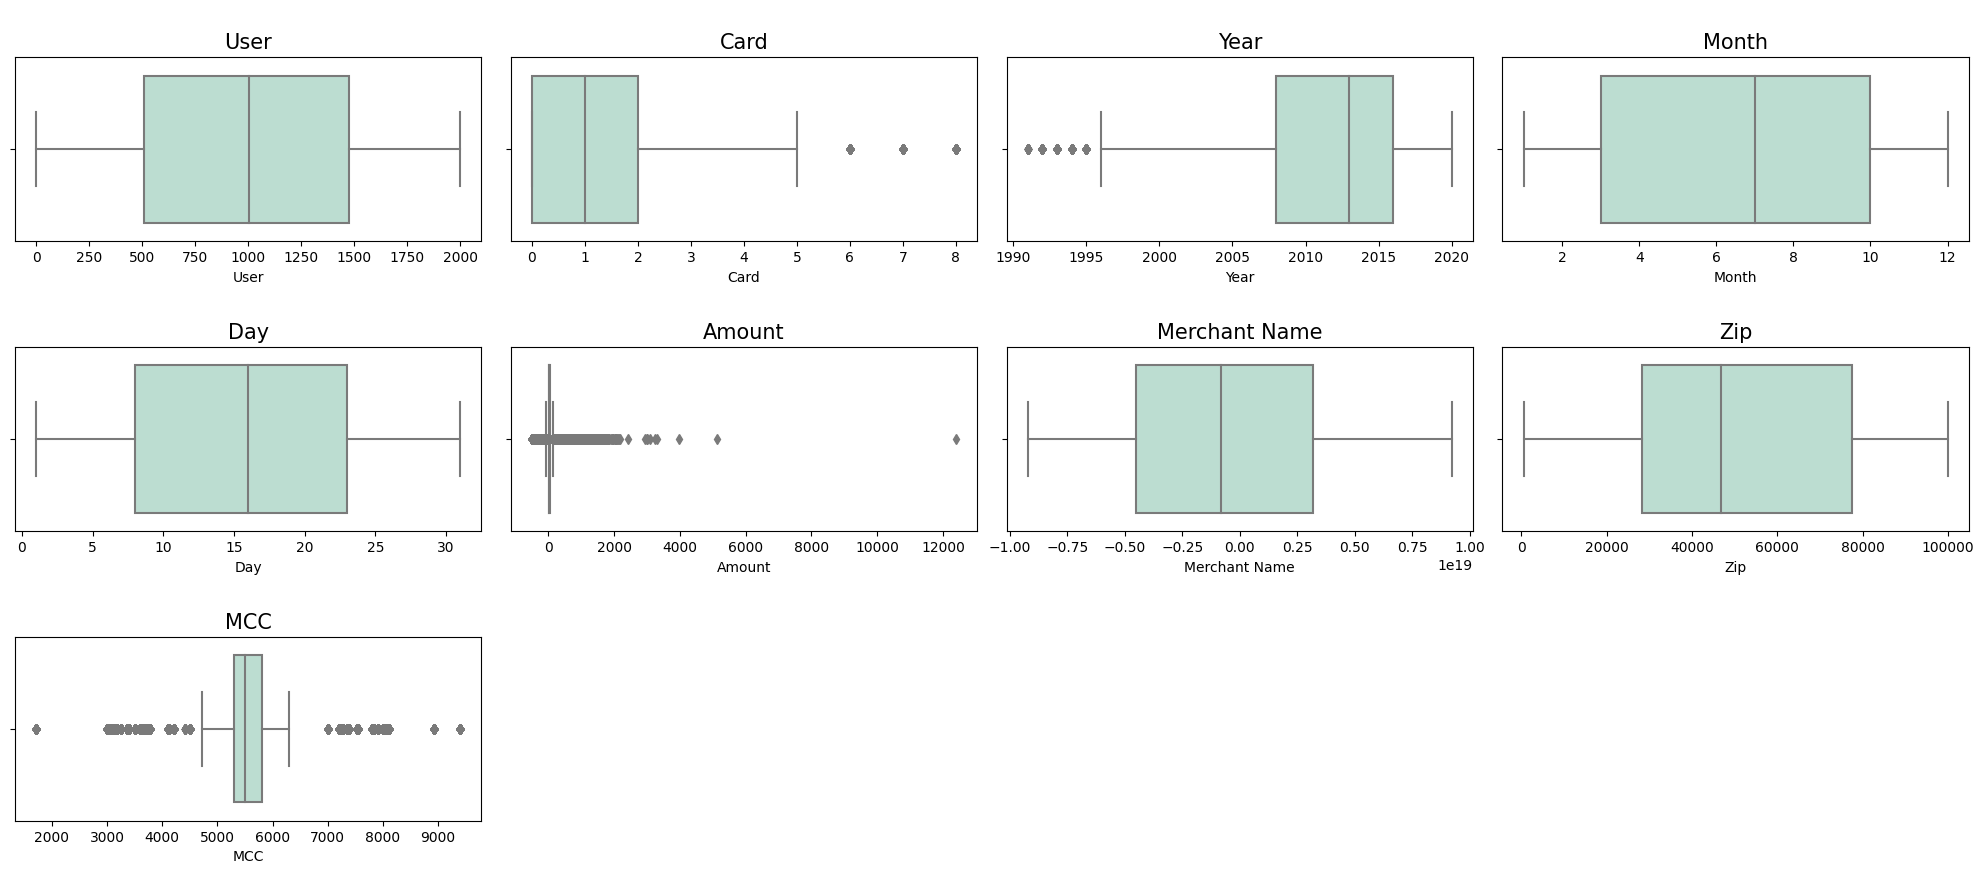

In [74]:
# Display the boxplot of numerical features
plt.figure(figsize = (20, 20))
plotnumber = 1

for feature in numerical_features:
    if feature != 'Is Fraud?':
        x = df_sample[feature]
        ax = plt.subplot(7, 4, plotnumber)
        sns.boxplot(x = x, color=colors[0])
        plt.title(f"\n{df_sample[feature].name}", fontsize = 15)
        plotnumber += 1
plt.tight_layout()
plt.show()

Stacked Bar Chart: Compare categories

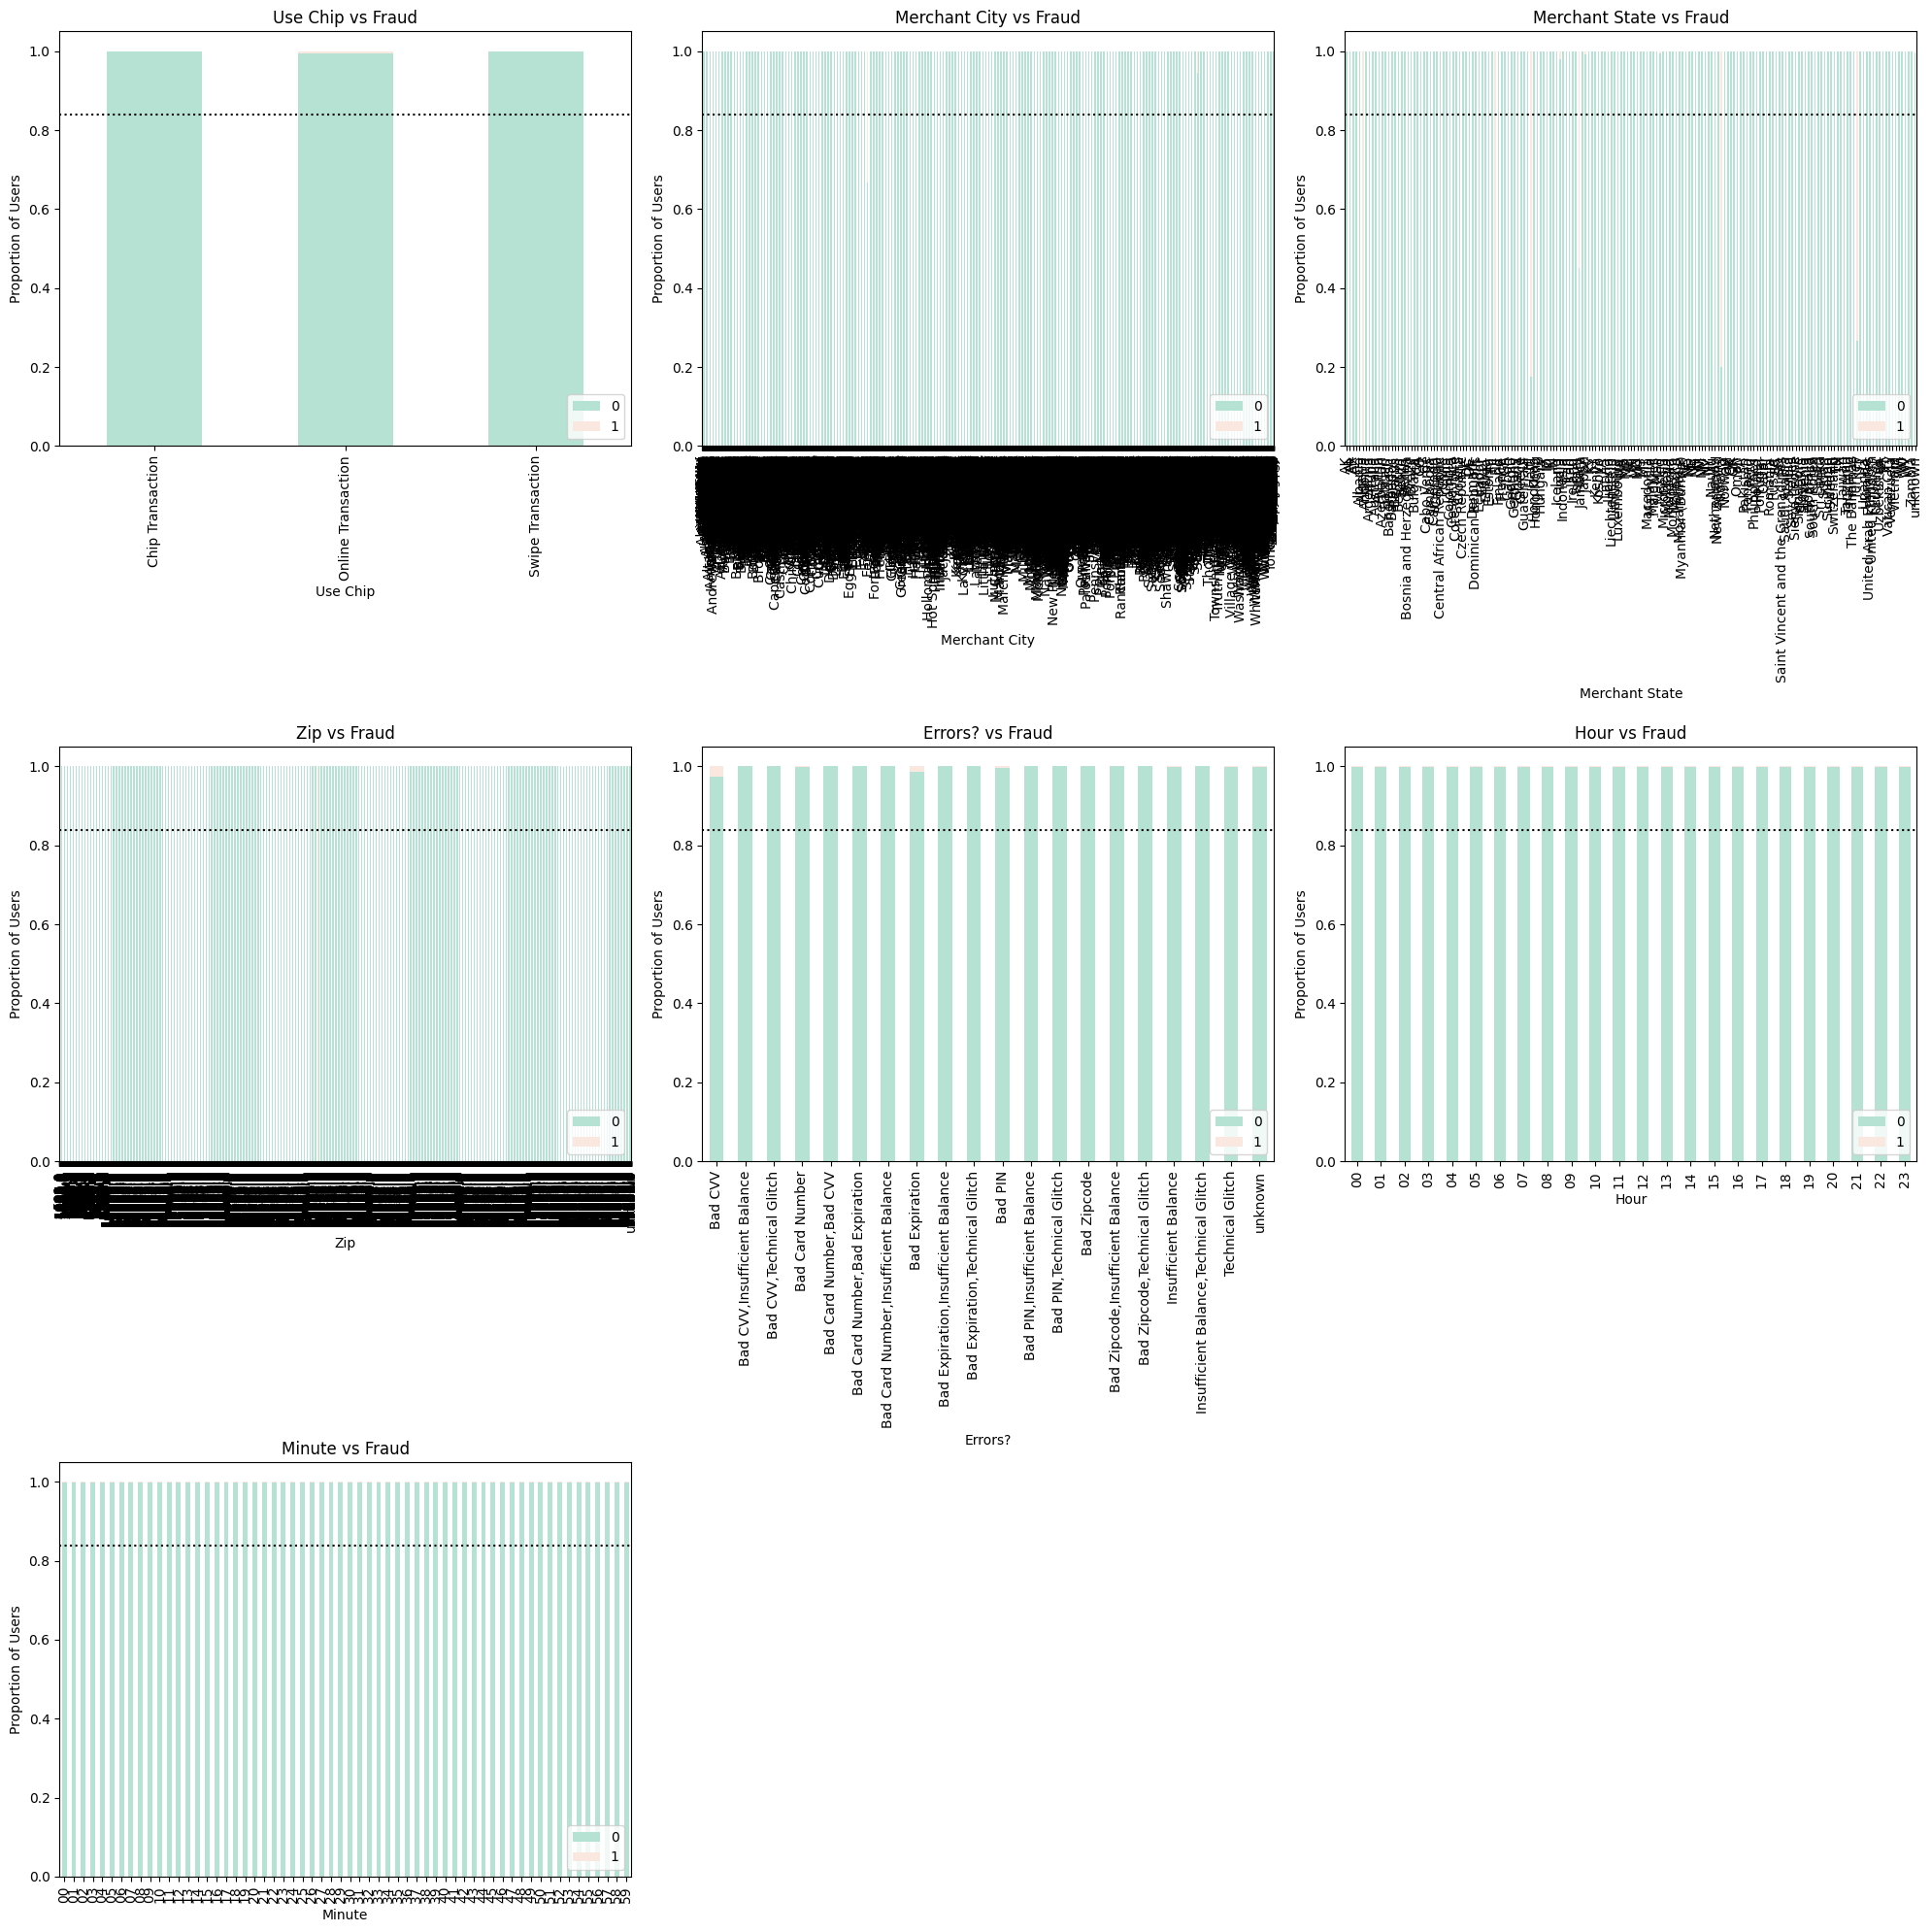

In [24]:
# Display stacked bar chart of categorical features
plt.figure(figsize = (20, 20))
plotnumber = 1
for feature in categorical_features:
    x = df_sample[feature]
    ax = plt.subplot(3,3,plotnumber)   
    table=pd.crosstab(df_sample[feature],df_sample['Is Fraud?'])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',ax=ax, stacked=True, color = colors).legend(loc='lower right')
    plt.title(f'{feature} vs Fraud')
    plt.ylabel('Proportion of Users')
    plt.axhline(0.83934, color='black', ls='dotted')  # Baseline: Overall fraud rate
    plotnumber += 1

plt.tight_layout()
plt.show()

In [25]:
df_sample.head(10)


,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
4866429,413,1,2011,3,15,50.43,Swipe Transaction,-3220758452254689706,Spokane,WA,99208.0,5311,unknown,0,07,50
5124282,433,1,2015,9,20,53.78,Online Transaction,-2088492411650162548,ONLINE,unknown,unknown,4784,unknown,0,05,30
17887935,1442,3,2020,2,10,30.98,Chip Transaction,-4113349227963201766,Lakeland,FL,33813.0,5411,unknown,0,11,41
7224963,610,2,2017,10,13,10.32,Swipe Transaction,6913268435708117971,Albuquerque,NM,87121.0,5912,unknown,0,18,32
19812059,1606,1,2009,5,18,130.45,Swipe Transaction,4937803722023861373,Stockton,CA,95210.0,5310,unknown,0,10,44
11960960,987,0,2019,1,6,65.42,Chip Transaction,6181510752141427450,Avoca,MI,48006.0,7538,unknown,0,06,08
17818383,1437,1,2013,12,27,104.29,Swipe Transaction,-5467922351692495955,Brooklyn,NY,11222.0,5912,unknown,0,14,45
12724868,1043,1,2018,8,18,44.24,Online Transaction,7035602569409149834,ONLINE,unknown,unknown,5311,unknown,0,12,09
5643279,484,1,2014,4,10,23.36,Online Transaction,-6160036380778658394,ONLINE,unknown,unknown,4121,unknown,0,08,14
13196474,1081,4,2017,9,16,17.17,Chip Transaction,4751695835751691036,Nashville,TN,37211.0,5814,unknown,0,11,57


In [77]:
getDataSummary(df_sample)

,data_type,count_unique_values,count_null
User,int64,1978,0
Card,int64,9,0
Year,int64,30,0
Month,int64,12,0
Day,int64,31,0
Amount,float64,32072,0
Use Chip,object,3,0
Merchant Name,int64,30165,0
Merchant City,object,9021,0
Merchant State,object,177,89228


**Observations:**

- User (not relevant)	
- Card	
- Year(not relevant)
- Month	
- Day		
- Hour 
- Minute (not relevant)
- Amount	
- Use Chip
- Merchant Name (not relevant)	
- Merchant City	
- Merchant State	
- Zip 
- MCC		
- Errors?

#### Correlation Heatmap

In [78]:
# # Correlation Heat Map: Pair-wise correlation
# plt.figure(figsize=(30,30))
# sns.heatmap(df_sample.corr(), annot=True, cmap='YlGnBu')  #coolwarm
# plt.title('Correlation Matrix')
# plt.show()

----------
## Feature Selection
----------

In [26]:
# Divide into independent and dependent variables
y = df_sample['Is Fraud?']
X = df_sample.drop(['Is Fraud?', 'User','Year', 'Minute', 'Merchant Name'], axis=1)

In [27]:
X

,Card,Month,Day,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors?,Hour
4866429,1,3,15,50.43,Swipe Transaction,Spokane,WA,99208.0,5311,unknown,07
5124282,1,9,20,53.78,Online Transaction,ONLINE,unknown,unknown,4784,unknown,05
17887935,3,2,10,30.98,Chip Transaction,Lakeland,FL,33813.0,5411,unknown,11
7224963,2,10,13,10.32,Swipe Transaction,Albuquerque,NM,87121.0,5912,unknown,18
19812059,1,5,18,130.45,Swipe Transaction,Stockton,CA,95210.0,5310,unknown,10
...,...,...,...,...,...,...,...,...,...,...,...
4231271,4,11,9,84.54,Swipe Transaction,Chicago,IL,60623.0,5300,unknown,13
23868796,1,7,25,-71.00,Swipe Transaction,Philadelphia,PA,19136.0,5541,unknown,18
21303691,1,1,19,59.64,Chip Transaction,Memphis,TN,38104.0,5541,unknown,10
10395349,3,7,9,85.52,Swipe Transaction,Clearwater,FL,33761.0,5411,unknown,16


----------
## Model Training
----------

#### ---Splitting Training and Test Sets---

In [28]:
# Split the dataset into y and x
print('Dependent Variable:')
print(y.name)

print('\nIndependent Variables:',len(X.columns))
print(X.columns)

Dependent Variable:
Is Fraud?

Independent Variables: 11
Index(['Card', 'Month', 'Day', 'Amount', 'Use Chip', 'Merchant City',
       'Merchant State', 'Zip', 'MCC', 'Errors?', 'Hour'],
      dtype='object')


In [29]:
# Split the data into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

print('X Train:',X_train.shape)
print('Y Train:',y_train.shape)
print('X Test:',X_test.shape)
print('Y Test:',y_test.shape)
X_train.head()

X Train: (640000, 11)
Y Train: (640000,)
X Test: (160000, 11)
Y Test: (160000,)


,Card,Month,Day,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors?,Hour
13834213,2,9,28,35.69,Online Transaction,ONLINE,unknown,unknown,4784,unknown,11
13486254,6,2,7,22.32,Swipe Transaction,Vacaville,CA,95687.0,4121,unknown,12
11232954,2,7,16,7.27,Swipe Transaction,Philadelphia,PA,19146.0,7538,unknown,12
13794879,0,4,1,49.55,Online Transaction,ONLINE,unknown,unknown,4784,unknown,21
23571117,4,2,8,0.00,Swipe Transaction,Gastonia,NC,28056.0,4829,unknown,17


#### ---Standardize/Scale Numerical Features---

In [30]:
X_train_final = X_train
# # Save a copy of the stats for scoring purposes
# scaling_parameters = X_train.describe()

# # Output parameters as csv file
# scaling_parameters.to_csv('Credit Card Customer Attrition - Scaling Parameters.csv')

# scaling_parameters.head()

In [84]:
# # Scale numerical features
                
# def ScaleData(in_data):
#     out_data = in_data.copy()
    
#     for colname in out_data.columns:

#         if colname in numerical_features:
            
#             # New column name                        
#             new_colname = 'Std_' + colname

#             # To scale, use the mean and standard deviation of the train dataset
#             feature_mean = scaling_parameters[colname]['mean']
#             feature_std = scaling_parameters[colname]['std']
            
#             # Scale: z = (x - mean) / std
#             out_data[new_colname] = ( out_data[colname] - feature_mean ) / feature_std

#             out_data.drop(columns=colname, inplace=True)
#             print(f"Scaling {colname} --> {new_colname} --> Mean={round(feature_mean,4)}, STD={round(feature_std,4)}")
            
#     return out_data
    
# # Scale features in the train set
# X_train_final = ScaleData(X_train)
# X_train_final.head()

# # Scale features in the test set
# X_test_final = ScaleData(X_test)
# X_test_final.head()

### Oversampling Using SMOTE (Synthetic Minority Oversampling Technique) Algorithm

In [36]:
categorical_features = []
for i in df_sample.columns:
    if df_sample[i].dtype == 'object':
        categorical_features.append(i)  # Append to the list of categorical features
categorical_features

['Use Chip',
 'Merchant City',
 'Merchant State',
 'Zip',
 'Errors?',
 'Hour',
 'Minute']

In [37]:
oversample = SMOTENC(random_state=1234, categorical_features=categorical_features)

X_oversample,y_oversample = oversample.fit_resample(X_train_final, y_train)

# Class distribution of the original training dataset / before performing SMOTE
print('\nBefore Oversampling:')
print('No. of Observations:',len(y_train))
print(y_train['Attrition_Flag'].value_counts() / len(y_train))

# Class distribution after performing SMOTE
print('\nAfter Oversampling:')
print('No. of Observations:',len(y_oversample))
print(y_oversample['Attrition_Flag'].value_counts() / len(y_oversample))

ValueError: Some of the categorical indices are out of range. Indices should be between 0 and 10

<!-- ![separator1](https://i.imgur.com/RQnsV0w.png) -->
----------
# **Decision Tree**
----------

### Fit Decision Tree Model

<!-- ![separator1](https://i.imgur.com/ZUWYTii.png) -->
----------
# Evaluate Decision Tree Model
<!-- Get model summary as dataframe -->
 <!-- https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe -->
----------

#### Classification Score - Decision Tree

### Confusion Matrix - Decision Tree

----------
<!-- ![separator1](https://i.imgur.com/ZUWYTii.png) -->

**References**

Decision Tree:
- https://medium.com/@chyun55555/decision-tree-classifier-with-scikit-learn-from-python-e83f38079fea
- https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- https://medium.com/analytics-vidhya/how-to-carry-out-k-fold-cross-validation-on-an-imbalanced-classification-problem-6d3d942a8016
- https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952


**Installations**
- numpy                  1.24.1
- pandas                 1.5.3
- matplotlib             3.6.3
- seaborn                0.12.2
- scikit-learn           1.2.0
- imblearn               0.0
- statsmodels            0.13.5